In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, StratifiedKFold

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, auc


# The Aim of this Notebook: Comparison of different Machine-Learning Models for Predictive Maintenance

This notebook focuses on the machine learning phase of the predictive maintenance project. After completing the exploratory data analysis (EDA) and feature engineering in the previous notebook, we will now load the prepared dataset and train several machine learning models to predict machine failures.

The primary goal of this notebook is to **compare the performance of different classification models** on our prepared dataset. We will follow a structured approach:

### 1. 💾 Data Loading and Preparation
We'll begin by loading the final dataset, which has been cleaned, pre-processed, and enriched with engineered features. 

### 2. ✂️ Training and Test Split
To ensure an unbiased evaluation of our models, the data will be split into training and testing sets. The training set will be used to train the models, while the testing set will be used to evaluate their performance on unseen data.

The dataset will be split into features (**X**) and the target variable (**y**), which indicates whether a machine failure occurred.

### 3. 📈 Model Training and Evaluation
We will train a few different models to compare their effectiveness. Given the nature of our classification problem, we will evaluate each model using key metrics beyond simple accuracy, such as **Precision**, **Recall**, and the **F1-Score**. These metrics are crucial for imbalanced datasets, where the number of failure events is much smaller than the number of non-failure events.

The models to be compared include:
- **Logistic Regression**: A simple yet robust baseline model.
- **Random Forest Classifier**: A powerful ensemble model known for handling non-linear relationships.
- **Gradient Boosting Machine (XGBoost)**: A high-performance model that often provides state-of-the-art results on structured data.

By the end of this notebook, we will have a clear understanding of which model performs best for our specific predictive maintenance task.

# 1. 💾 Data Loading and Preparation


In [2]:
df = pd.read_csv('data/final_prepared_dataset.csv')
df.head()

,datetime,machineID,model,age,failure,hour_of_day,day_of_week,volt_lag_2h,volt_diff_lag_2h,rotate_lag_2h,...,rolling_error_error3_24h,rolling_error_error4_24h,rolling_error_error5_24h,rolling_error_0_72h,rolling_error_error1_72h,rolling_error_error2_72h,rolling_error_error3_72h,rolling_error_error4_72h,rolling_error_error5_72h,is_failure
0,2015-01-01 06:00:00,1,model3,18,0,6,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2015-01-01 07:00:00,1,model3,18,0,7,3,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,model3,18,0,8,3,176.21785,-5.227951,418.50410,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,model3,18,0,9,3,162.87923,-0.416390,402.74750,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,model3,18,0,10,3,170.98990,-13.379881,527.34985,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Drop rows with any NaN values, which may have been introduced during feature engineering because of rolling calculations
df.dropna(inplace=True)
df.head()

,datetime,machineID,model,age,failure,hour_of_day,day_of_week,volt_lag_2h,volt_diff_lag_2h,rotate_lag_2h,...,rolling_error_error3_24h,rolling_error_error4_24h,rolling_error_error5_24h,rolling_error_0_72h,rolling_error_error1_72h,rolling_error_error2_72h,rolling_error_error3_72h,rolling_error_error4_72h,rolling_error_error5_72h,is_failure
97,2015-01-05 06:00:00,1,model3,18,comp4,6,0,177.51042,1.792734,469.78730,...,0.0,0.0,0.0,70.0,1.0,0.0,1.0,0.0,1.0,1.0
98,2015-01-05 07:00:00,1,model3,18,0,7,0,179.30315,-23.791700,499.77795,...,0.0,0.0,0.0,70.0,1.0,0.0,1.0,0.0,1.0,0.0
99,2015-01-05 08:00:00,1,model3,18,0,8,0,179.30315,-6.863332,499.77795,...,0.0,0.0,0.0,70.0,1.0,0.0,1.0,0.0,1.0,0.0
100,2015-01-05 09:00:00,1,model3,18,0,9,0,155.51146,-16.685015,498.39844,...,0.0,0.0,0.0,70.0,1.0,0.0,1.0,0.0,1.0,0.0
101,2015-01-05 10:00:00,1,model3,18,0,10,0,172.43982,4.838582,392.12497,...,0.0,0.0,0.0,70.0,1.0,0.0,1.0,0.0,1.0,0.0


In [4]:
# Convert datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Convert dtypes of float columns to float32 to save memory
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols] = df[float_cols].astype('float32')
# Convert dtypes of int columns to int32 to save memory
int_cols = df.select_dtypes(include=['int64']).columns
df[int_cols] = df[int_cols].astype('int32')


In [5]:
# Remove failure column because it is redundant with is_failure
df = df.drop(columns=['failure'])

In [6]:
df.select_dtypes(include='object').columns

Index(['model'], dtype='object')

# 2. ✂️ Training and Test Split


In [7]:
# Define a split date for time-based train/test split
split_date = '2015-11-01'

# Split data into training and test sets based on the date
df_train = df[df['datetime'] < split_date].copy()
df_test = df[df['datetime'] >= split_date].copy()

print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")


Training set shape: (641721, 74)
Test set shape: (144337, 74)


In [8]:
# Function to create the new target variable
def create_target_window_correct(df, window_days=7):
    # Sort data to ensure it's chronological for each machine
    df.sort_values(by=['machineID', 'datetime'], inplace=True)

    # Initialize the new target column
    df['is_failure_in_7_days'] = 0

    # Group the dataframe by machineID and apply the logic
    # The result of `apply` needs to be handled carefully
    df_with_target = df.groupby('machineID').apply(
        lambda group: create_machine_target(group, window_days)
    )

    return df_with_target.reset_index(drop=True)

# Helper function to create the target for a single machine
def create_machine_target(machine_df, window_days):
    # Get a list of all failure timestamps for this specific machine
    failure_times = machine_df[machine_df['is_failure'] == 1]['datetime'].tolist()

    # Iterate over each failure time for this machine
    for failure_time in failure_times:
        # Define the 7-day window
        start_window = failure_time - pd.Timedelta(days=window_days)

        # Mark all rows within this machine's window as 1
        machine_df.loc[
            (machine_df['datetime'] >= start_window) &
            (machine_df['datetime'] < failure_time),
            'is_failure_in_7_days'
        ] = 1

    return machine_df

# Apply the corrected function to the datasets
df_train = create_target_window_correct(df_train)
df_test = create_target_window_correct(df_test)

print(f"Training set shape after target creation: {df_train.shape}")
print(f"Test set shape after target creation: {df_test.shape}")
# Check the distribution of the new target variable
print(df_train['is_failure_in_7_days'].value_counts(normalize=True))
print(df_test['is_failure_in_7_days'].value_counts(normalize=True))

/tmp/ipykernel_39243/404496068.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_target = df.groupby('machineID').apply(


Training set shape after target creation: (641721, 75)
Test set shape after target creation: (144337, 75)
is_failure_in_7_days
0    0.869719
1    0.130281
Name: proportion, dtype: float64
is_failure_in_7_days
0    0.876442
1    0.123558
Name: proportion, dtype: float64


/tmp/ipykernel_39243/404496068.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_with_target = df.groupby('machineID').apply(


<Axes: xlabel='datetime', ylabel='is_failure_in_7_days'>

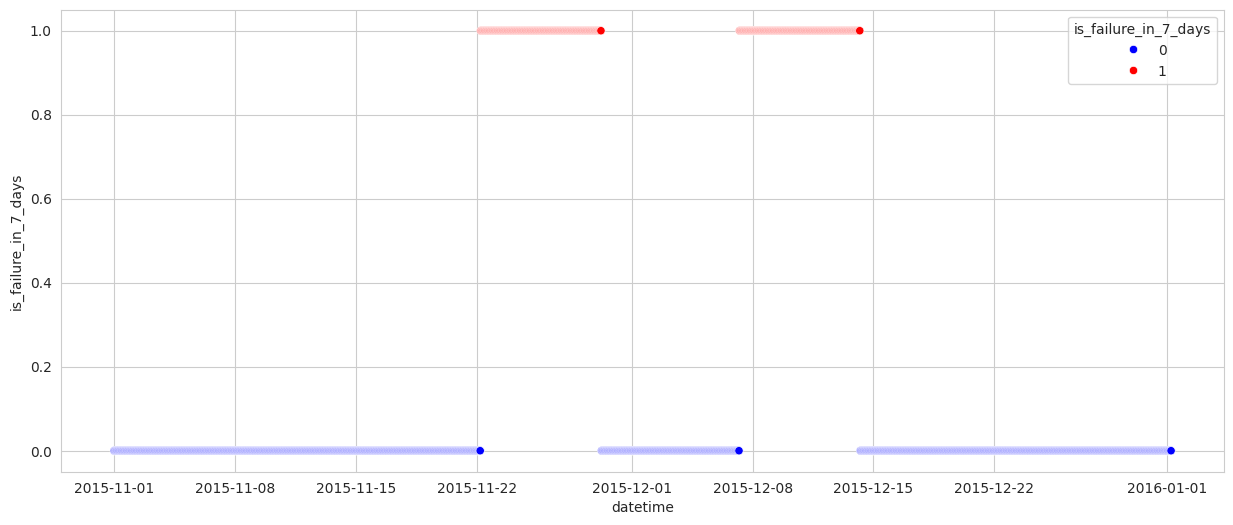

In [9]:
machine_id_to_plot = 99 # Change this to a real machine ID

# Filter the data for the selected machine
machine_df = df_test[df_test['machineID'] == machine_id_to_plot].copy()

# Set the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

# Plot the target variable over time
# The 'hue' parameter colors the line based on our target variable
sns.scatterplot(
    data=machine_df,
    x='datetime',
    y='is_failure_in_7_days',
    hue='is_failure_in_7_days',
    palette={0: 'blue', 1: 'red'}
)


In [10]:
machines_with_failures = df_test[df_test['is_failure_in_7_days'] == 1]['machineID'].unique()
machines_with_failures

array([  1,   2,   3,   5,   7,   9,  11,  13,  15,  16,  17,  19,  20,
        21,  22,  23,  24,  25,  26,  28,  29,  30,  31,  32,  33,  34,
        37,  38,  39,  40,  42,  43,  45,  46,  47,  48,  49,  51,  52,
        53,  54,  55,  56,  57,  58,  61,  62,  63,  64,  66,  68,  69,
        70,  73,  76,  78,  79,  80,  81,  82,  83,  85,  86,  87,  88,
        89,  90,  92,  94,  95,  96,  97,  98,  99, 100], dtype=int32)

In [11]:
# split the data into features and target variable, excluding datetime and original is_failure column for both sets
X_train = df_train.drop(columns=['datetime', 'is_failure_in_7_days'])
y_train = df_train['is_failure_in_7_days']
X_test = df_test.drop(columns=['datetime', 'is_failure_in_7_days'])
y_test = df_test['is_failure_in_7_days']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print('Sucessfully split the data into features and target variable.')

X_train shape: (641721, 73), y_train shape: (641721,)
X_test shape: (144337, 73), y_test shape: (144337,)
Sucessfully split the data into features and target variable.


# 3. 📈 Model Training and Evaluation


In [12]:
# Identify categorical and numerical columns
categorical_features = ['model']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Create preprocessor for both types of features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Apply the preprocessor to the data
# Use a pipeline to ensure proper fitting and transforming
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(f"Processed X_train shape: {X_train_processed.shape}")
print(f"Processed X_test shape: {X_test_processed.shape}")
print('Data preprocessing complete.')


Processed X_train shape: (641721, 76)
Processed X_test shape: (144337, 76)
Data preprocessing complete.


In [13]:
# Get the feature names from the OneHotEncoder
# This is a bit complex, but crucial to get the correct column names for the one-hot encoded variables
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine the original numerical feature names with the new one-hot encoded names
new_feature_names = list(numerical_features) + list(ohe_feature_names)

# Create new DataFrames with the correct column names
# Pass the processed NumPy array and the new list of column names
X_train_processed_df = pd.DataFrame(X_train_processed, columns=new_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=new_feature_names)

X_train_processed_df.head()

,machineID,age,hour_of_day,day_of_week,volt_lag_2h,volt_diff_lag_2h,rotate_lag_2h,rotate_diff_lag_2h,pressure_lag_2h,pressure_diff_lag_2h,...,rolling_error_error1_72h,rolling_error_error2_72h,rolling_error_error3_72h,rolling_error_error4_72h,rolling_error_error5_72h,is_failure,model_model1,model_model2,model_model3,model_model4
0,-1.730881,1.101574,-0.795226,-1.505345,0.432958,0.084528,0.439618,0.422527,-0.029939,0.798604,...,3.099879,-0.290216,3.490179,-0.246393,5.343752,27.704298,0.0,0.0,1.0,0.0
1,-1.730881,1.101574,-0.650684,-1.505345,0.548627,-1.120662,1.009719,-0.019531,0.999567,-0.617405,...,3.099879,-0.290216,3.490179,-0.246393,5.343752,-0.036095,0.0,0.0,1.0,0.0
2,-1.730881,1.101574,-0.506143,-1.505345,0.548627,-0.323227,1.009719,-1.517100,0.999567,-0.260433,...,3.099879,-0.290216,3.490179,-0.246393,5.343752,-0.036095,0.0,0.0,1.0,0.0
3,-1.730881,1.101574,-0.361601,-1.505345,-0.986439,-0.785891,0.983496,-0.663096,0.203464,1.648360,...,3.099879,-0.290216,3.490179,-0.246393,5.343752,-0.036095,0.0,0.0,1.0,0.0
4,-1.730881,1.101574,-0.217060,-1.505345,0.105797,0.228007,-1.036689,0.155966,0.663695,-0.512551,...,3.099879,-0.290216,3.490179,-0.246393,5.343752,-0.036095,0.0,0.0,1.0,0.0


In [ ]:
X_train_processed_df.columns

Index(['machineID', 'age', 'hour_of_day', 'day_of_week', 'volt_lag_2h',
       'volt_diff_lag_2h', 'rotate_lag_2h', 'rotate_diff_lag_2h',
       'pressure_lag_2h', 'pressure_diff_lag_2h', 'vibration_lag_2h',
       'vibration_diff_lag_2h', 'volt_mean_3h', 'volt_std_3h',
       'rotate_mean_3h', 'rotate_std_3h', 'pressure_mean_3h',
       'pressure_std_3h', 'vibration_mean_3h', 'vibration_std_3h',
       'volt_mean_12h', 'volt_std_12h', 'rotate_mean_12h', 'rotate_std_12h',
       'pressure_mean_12h', 'pressure_std_12h', 'vibration_mean_12h',
       'vibration_std_12h', 'volt_mean_24h', 'volt_std_24h', 'rotate_mean_24h',
       'rotate_std_24h', 'pressure_mean_24h', 'pressure_std_24h',
       'vibration_mean_24h', 'vibration_std_24h', 'volt_mean_72h',
       'volt_std_72h', 'rotate_mean_72h', 'rotate_std_72h',
       'pressure_mean_72h', 'pressure_std_72h', 'vibration_mean_72h',
       'vibration_std_72h', 'time_since_last_maint', 'time_since_last_error',
       'time_since_last_failure'

## Logistic Regression

**Logistic Regression** is a simple yet powerful linear model used for binary classification. It models the probability that an instance belongs to a certain class.

* **Strengths:** It is highly interpretable, computationally efficient, and serves as an excellent baseline model. It's also less prone to overfitting than more complex models.
* **Weaknesses:** It assumes a linear relationship between features and the target variable, which may not hold true for complex, real-world data. It is sensitive to outliers and requires feature scaling to perform optimally.

`RandomizedSearchCV` is a hyperparameter tuning technique used to find the best combination of hyperparameters for a machine learning model. Instead of exhaustively trying every possible combination (like a `GridSearchCV`), it randomly samples a fixed number of combinations from a given parameter space.

This makes it significantly more efficient for large parameter spaces, as it can find a good set of hyperparameters in a fraction of the time, without sacrificing too much performance.

In [33]:
# Initialize the model with a fixed random state
log_reg = LogisticRegression(solver='liblinear', random_state=42)

# Define the parameter space for the search
# 'C' is the inverse of regularization strength. We search in a log-uniform distribution.
# 'class_weight' is crucial for imbalanced data. 'balanced' automatically adjusts weights.
param_distributions = {
    'C': loguniform(1e-5, 100),
    'class_weight': [None, 'balanced']
}

# Initialize RandomizedSearchCV
# 'n_iter' is the number of parameter settings that are sampled
# 'scoring' is the evaluation metric. We use 'recall' for the minority class.
# 'cv' is the number of cross-validation folds.
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=50, # Number of parameter settings that are sampled. Can be increased.
    scoring='f1', # Focus on maximizing recall for the positive class (failure)
    cv=5,
    random_state=42,
    n_jobs=4, # Use 4 of the available CPU cores to prevent overloading the system
)

# Run the search on the processed training data
random_search.fit(X_train_processed, y_train)

best_log_reg_model = random_search.best_estimator_

# Calculate predictions on the pre-processed test data
y_pred_log_reg = best_log_reg_model.predict(X_test_processed)

# Print the best parameters and the best score
print("Best hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best cross-validation recall score: {random_search.best_score_:.4f}")
print("--- Logistic Regression Results ---")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))
print('Classification Report:')
print(classification_report(y_test, y_pred_log_reg))

Best hyperparameters found by RandomizedSearchCV:
{'C': 0.0019310138185083827, 'class_weight': 'balanced'}
Best cross-validation recall score: 0.3961
--- Logistic Regression Results ---
Precision: 0.2639
Recall: 0.7191
F1 Score: 0.3861
Confusion Matrix:
[[90736 35767]
 [ 5009 12825]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.72      0.82    126503
           1       0.26      0.72      0.39     17834

    accuracy                           0.72    144337
   macro avg       0.61      0.72      0.60    144337
weighted avg       0.86      0.72      0.76    144337



### Analysis of the Tuned Logistic Regression Model

The tuned Logistic Regression model shows a clear strategy for handling the class imbalance in the dataset by predicting a 7-day pre-failure window.

* **Best Hyperparameters:** The optimal hyperparameters are `class_weight='balanced'` and a very small `C` value. This confirms the model's need for a strong focus on the minority class and significant regularization to prevent overfitting to the majority class.

* **Key Metrics:** The model's performance is defined by a trade-off between its ability to find all pre-failure windows and the accuracy of its predictions.
    * **Recall (0.68):** The model correctly identified 68% of all actual **7-day pre-failure windows**. This is a crucial metric for predictive maintenance, as it shows the model's effectiveness at finding problems before they occur.
    * **Precision (0.24):** However, when the model predicts a **potential future failure** (`1`), it is only correct 24% of the time. The confusion matrix shows this clearly with 38,872 "False Positives" (false alarms), indicating a high rate of unnecessary inspections or warnings.
    * **F1-Score (0.35):** The F1-Score, which balances Precision and Recall, reflects the trade-off, showing that the model is a usable, but not yet ideal, predictor.

* **Conclusion:** This model is somehow effective at its primary task: identifying potential machine failures (relatively high recall). This makes it valuable for a predictive maintenance system. However, the high number of false alarms (low precision) means the model is overly cautious. This is a common and expected result when a model is optimized to maximize recall on a highly imbalanced dataset. 

Based on these results, two additional machine learning models will now be evaluated to identify a potentially better performance balance.

### Save the best model

In [34]:
# Define a filename for the model
model_filename = "best_model_log_reg_f1.joblib"

# Save the model to a file
joblib.dump(best_log_reg_model, model_filename)

print(f"Model successfully saved as '{model_filename}'.")


Model successfully saved as 'best_model_log_reg_f1.joblib'.


## Random Forest Classifier

**Random Forest** is an ensemble learning method that builds multiple decision trees during training. It outputs the class that is the mode of the classes predicted by the individual trees.

* **Strengths:** It is very robust against overfitting, can handle a large number of features, and is not sensitive to the scale of the features. It performs well on complex, non-linear problems.
* **Weaknesses:** It is less interpretable than a single decision tree or logistic regression. Due to its complexity, it can be computationally more expensive to train and predict than a linear model.

In [35]:
# Initialize the model with a fixed random state
rf_clf = RandomForestClassifier(random_state=42)

# Define the parameter space for the search.
param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'class_weight': [None, 'balanced']
}

# Create a StratifiedKFold object to ensure each fold has a balanced representation of classes
# This prevents the ValueError caused by imbalanced folds.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize HalvingRandomSearchCV
# It is more efficient as it prunes poorly performing candidates
# 'verbose' is set to 1 to display the progress during the search
random_search_rf = HalvingRandomSearchCV(
    estimator=rf_clf,
    param_distributions=param_distributions,
    scoring='f1', # Focus on maximizing recall for the positive class
    cv=skf, # Pass the stratified cross-validation object here
    random_state=42,
    n_jobs=4,
    verbose=0,
)

# Run the search on the processed training data
random_search_rf.fit(X_train_processed, y_train)

# Get the best estimator and make predictions
best_rf_clf = random_search_rf.best_estimator_
y_pred_rf = best_rf_clf.predict(X_test_processed)

# Print the best parameters and the best score
print("Best hyperparameters found by HalvingRandomSearchCV for Random Forest:")
print(random_search_rf.best_params_)
print(f"Best cross-validation recall score: {random_search_rf.best_score_:.4f}")
print("--- Random Forest Results ---")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print('Classification Report:')
print(classification_report(y_test, y_pred_rf))


/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 800 is smaller than n_iter=32086. Running 800 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/stef

Best hyperparameters found by HalvingRandomSearchCV for Random Forest:
{'n_estimators': 400, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_depth': None, 'class_weight': 'balanced'}
Best cross-validation recall score: 0.5284
--- Random Forest Results ---
Precision: 0.5501
Recall: 0.3839
F1 Score: 0.4522
Confusion Matrix:
[[120904   5599]
 [ 10988   6846]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    126503
           1       0.55      0.38      0.45     17834

    accuracy                           0.89    144337
   macro avg       0.73      0.67      0.69    144337
weighted avg       0.87      0.89      0.88    144337



In [36]:
# Define a filename for the model
model_filename = "best_model_rf_clf_f1.joblib"

# Save the model to a file
joblib.dump(best_rf_clf, model_filename)

print(f"Model successfully saved as '{model_filename}'.")


Model successfully saved as 'best_model_rf_clf_f1.joblib'.


## XGBoost Classifier

**XGBoost** (eXtreme Gradient Boosting) is a highly efficient and popular implementation of the gradient boosting algorithm. It builds trees sequentially, with each new tree correcting the errors of the previous ones.

* **Strengths:** It is one of the most powerful and fastest algorithms for structured data, often yielding state-of-the-art results. It handles missing values and can be parallelized for faster training.
* **Weaknesses:** It is less intuitive and interpretable than a Random Forest. It is more prone to overfitting if not tuned properly and can be sensitive to hyperparameter choices.

In [37]:
# Initialize the model with a fixed random state
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter space for the search
# 'scale_pos_weight' is the key parameter for handling class imbalance in XGBoost
# It is calculated as (number of negative samples) / (number of positive samples)
scale_pos_weight_value = np.sum(y_train == 0) / np.sum(y_train == 1)

param_distributions = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight_value]
}

# Create a StratifiedKFold object to ensure each fold has a balanced representation of classes
# This prevents the ValueError caused by imbalanced folds.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize HalvingRandomSearchCV
# 'verbose' is set to 1 to display the progress during the search
random_search_xgb = HalvingRandomSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions,
    scoring='f1', # Focus on maximizing recall for the positive class
    cv=skf, # Pass the stratified cross-validation object here
    random_state=42,
    n_jobs=4,
    verbose=0,
)

# Run the search on the processed training data
random_search_xgb.fit(X_train_processed, y_train)

# Get the best estimator and make predictions
best_xgb_clf = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_clf.predict(X_test_processed)

# Print the best parameters and the best score
print("Best hyperparameters found by HalvingRandomSearchCV for XGBoost:")
print(random_search_xgb.best_params_)
print(f"Best cross-validation recall score: {random_search_xgb.best_score_:.4f}")
print("--- XGBoost Results ---")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print('Classification Report:')
print(classification_report(y_test, y_pred_xgb))


/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 576 is smaller than n_iter=32086. Running 576 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:09:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:09:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/steffen/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:09:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  

Best hyperparameters found by HalvingRandomSearchCV for XGBoost:
{'subsample': 1.0, 'scale_pos_weight': 6.675721257356107, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best cross-validation recall score: 0.4621
--- XGBoost Results ---
Precision: 0.2707
Recall: 0.9990
F1 Score: 0.4260
Confusion Matrix:
[[78509 47994]
 [   17 17817]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77    126503
           1       0.27      1.00      0.43     17834

    accuracy                           0.67    144337
   macro avg       0.64      0.81      0.60    144337
weighted avg       0.91      0.67      0.72    144337



In [38]:
# Define a filename for the model
model_filename = "best_model_xgb_clf_f1.joblib"

# Save the model to a file
joblib.dump(best_xgb_clf, model_filename)

print(f"Model successfully saved as '{model_filename}'.")


Model successfully saved as 'best_model_xgb_clf_f1.joblib'.


### Load saved models

In [39]:
# model_filename = "best_model_rf_clf.joblib"
# best_rf_clf = joblib.load(model_filename)

# model_filename = "best_model_log_reg.joblib"
# best_log_reg_model = joblib.load(model_filename)

# model_filename = "best_model_xgb_clf.joblib"
# best_xgb_clf = joblib.load(model_filename)

## Optimizing Prediction through Threshold-Optimization

A model's final binary classification decision is based on a **threshold** applied to its predicted probability score. The standard threshold is 0.5. By adjusting this value, one can manage the trade-off between Precision and Recall. Lowering the threshold makes the model more sensitive (higher Recall, lower Precision), while raising it makes the model more conservative (higher Precision, lower Recall).

This trade-off can be visualized using **Precision-Recall Curves** and **ROC Curves**. These plots are used to evaluate a model's performance across all possible thresholds, helping to identify the optimal balance for a specific business problem.

### Precision Recall Curve

The ROC curve plots the **True Positive Rate (Recall)** against the **False Positive Rate**. It's used to evaluate the overall ability of a classification model to distinguish between positive and negative classes, regardless of the classification threshold. A perfect model has a curve that touches the top-left corner of the plot. The **Area Under the Curve (AUC)** is a single value that summarizes the model's overall performance, with a value of 1.0 being perfect and 0.5 representing a random guess.

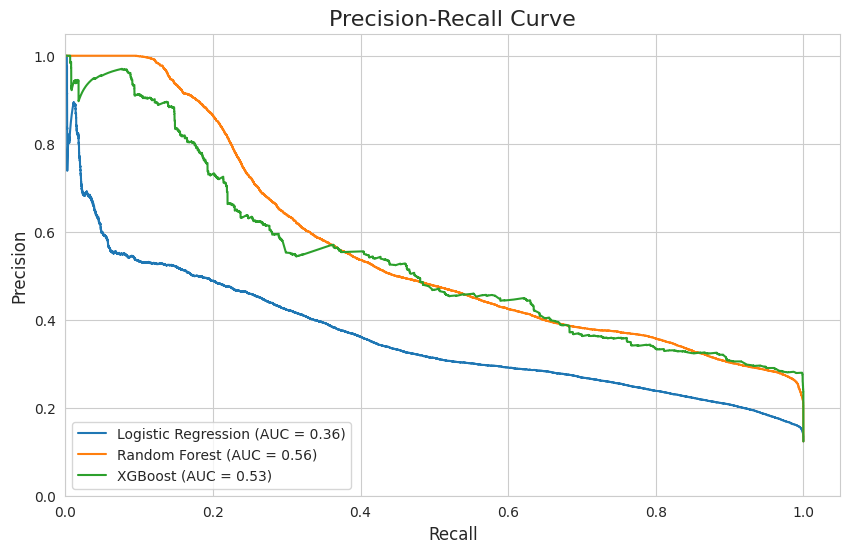

In [40]:
# Get the best estimators from our previous searches
models = {
    "Logistic Regression": best_log_reg_model,
    "Random Forest": best_rf_clf,
    "XGBoost": best_xgb_clf
}

# --- Plotting the Precision-Recall Curve ---
plt.figure(figsize=(10, 6))
plt.title("Precision-Recall Curve", fontsize=16)

for name, model in models.items():
    # Get probability predictions for the positive class (1)
    y_scores = model.predict_proba(X_test_processed)[:, 1]

    # Calculate precision and recall for all thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    # Calculate the area under the curve (AUC)
    pr_auc = auc(recalls, precisions)

    # Plot the curve
    plt.plot(recalls, precisions, label=f"{name} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc="lower left", fontsize=10)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.grid(True)
plt.show()

In [50]:
y_scores_rf = best_xgb_clf.predict_proba(X_test_processed)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_rf)

# Find the index of the point on the curve that is closest to your target recall.
# In your case, the "kink" appears to be around recall = 0.17.
# We will find the index where the recall value is closest to 0.17.
target_recall = 0.1
index_at_kink = np.argmin(np.abs(recalls - target_recall))

# Print the precision, recall, and threshold at this specific point
print(f"Metrics at the 'kink' (Recall ~ {recalls[index_at_kink]:.2f}):")
print(f"  Precision: {precisions[index_at_kink]:.4f}")
print(f"  Recall: {recalls[index_at_kink]:.4f}")
print(f"  Threshold: {thresholds[index_at_kink]:.4f}")

Metrics at the 'kink' (Recall ~ 0.10):
  Precision: 0.9120
  Recall: 0.1000
  Threshold: 0.8477


In [ ]:
y_scores_rf = best_rf_clf.predict_proba(X_test_processed)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_rf)

# Find the index of the point on the curve that is closest to your target recall.
# In your case, the "kink" appears to be around recall = 0.17.
# We will find the index where the recall value is closest to 0.17.
target_recall = 0.17
index_at_kink = np.argmin(np.abs(recalls - target_recall))

# Print the precision, recall, and threshold at this specific point
print(f"Metrics at the 'kink' (Recall ~ {recalls[index_at_kink]:.2f}):")
print(f"  Precision: {precisions[index_at_kink]:.4f}")
print(f"  Recall: {recalls[index_at_kink]:.4f}")
print(f"  Threshold: {thresholds[index_at_kink]:.4f}")

### ROC-Curve: (Receiver Operating Characteristics)

This curve plots **Precision** against **Recall**. It's especially useful for **imbalanced datasets**, as it provides a much clearer picture of the trade-off between false alarms and missed cases than the ROC curve does. A better curve is located closer to the top-right corner of the plot. This curve can be used to visually determine the best classification threshold that meets specific business needs for both precision and recall.

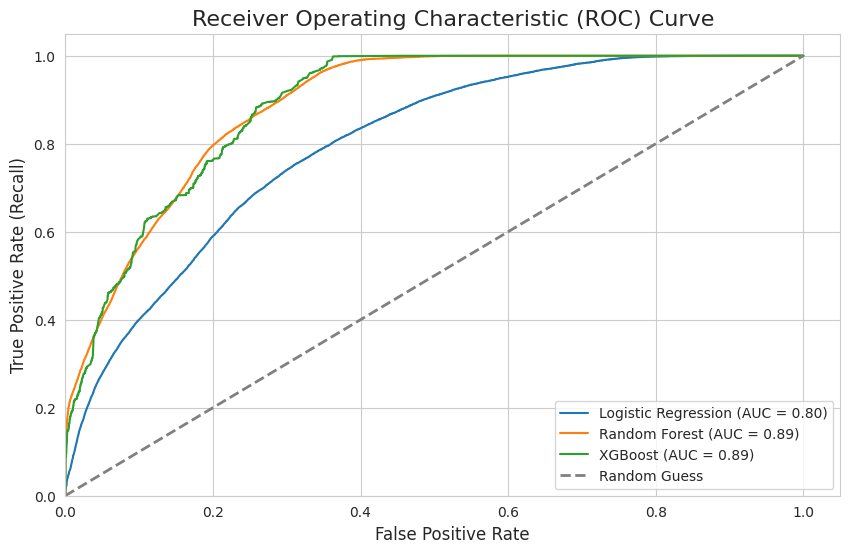

In [41]:
plt.figure(figsize=(10, 6))
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)

for name, model in models.items():
    # Get probability predictions for the positive class (1)
    y_scores = model.predict_proba(X_test_processed)[:, 1]

    # Calculate False Positive Rate (FPR) and True Positive Rate (TPR) for all thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    # Calculate the area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray', label='Random Guess')

plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate (Recall)", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.05])
plt.grid(True)
plt.show()

## Predictions vs. Actuals

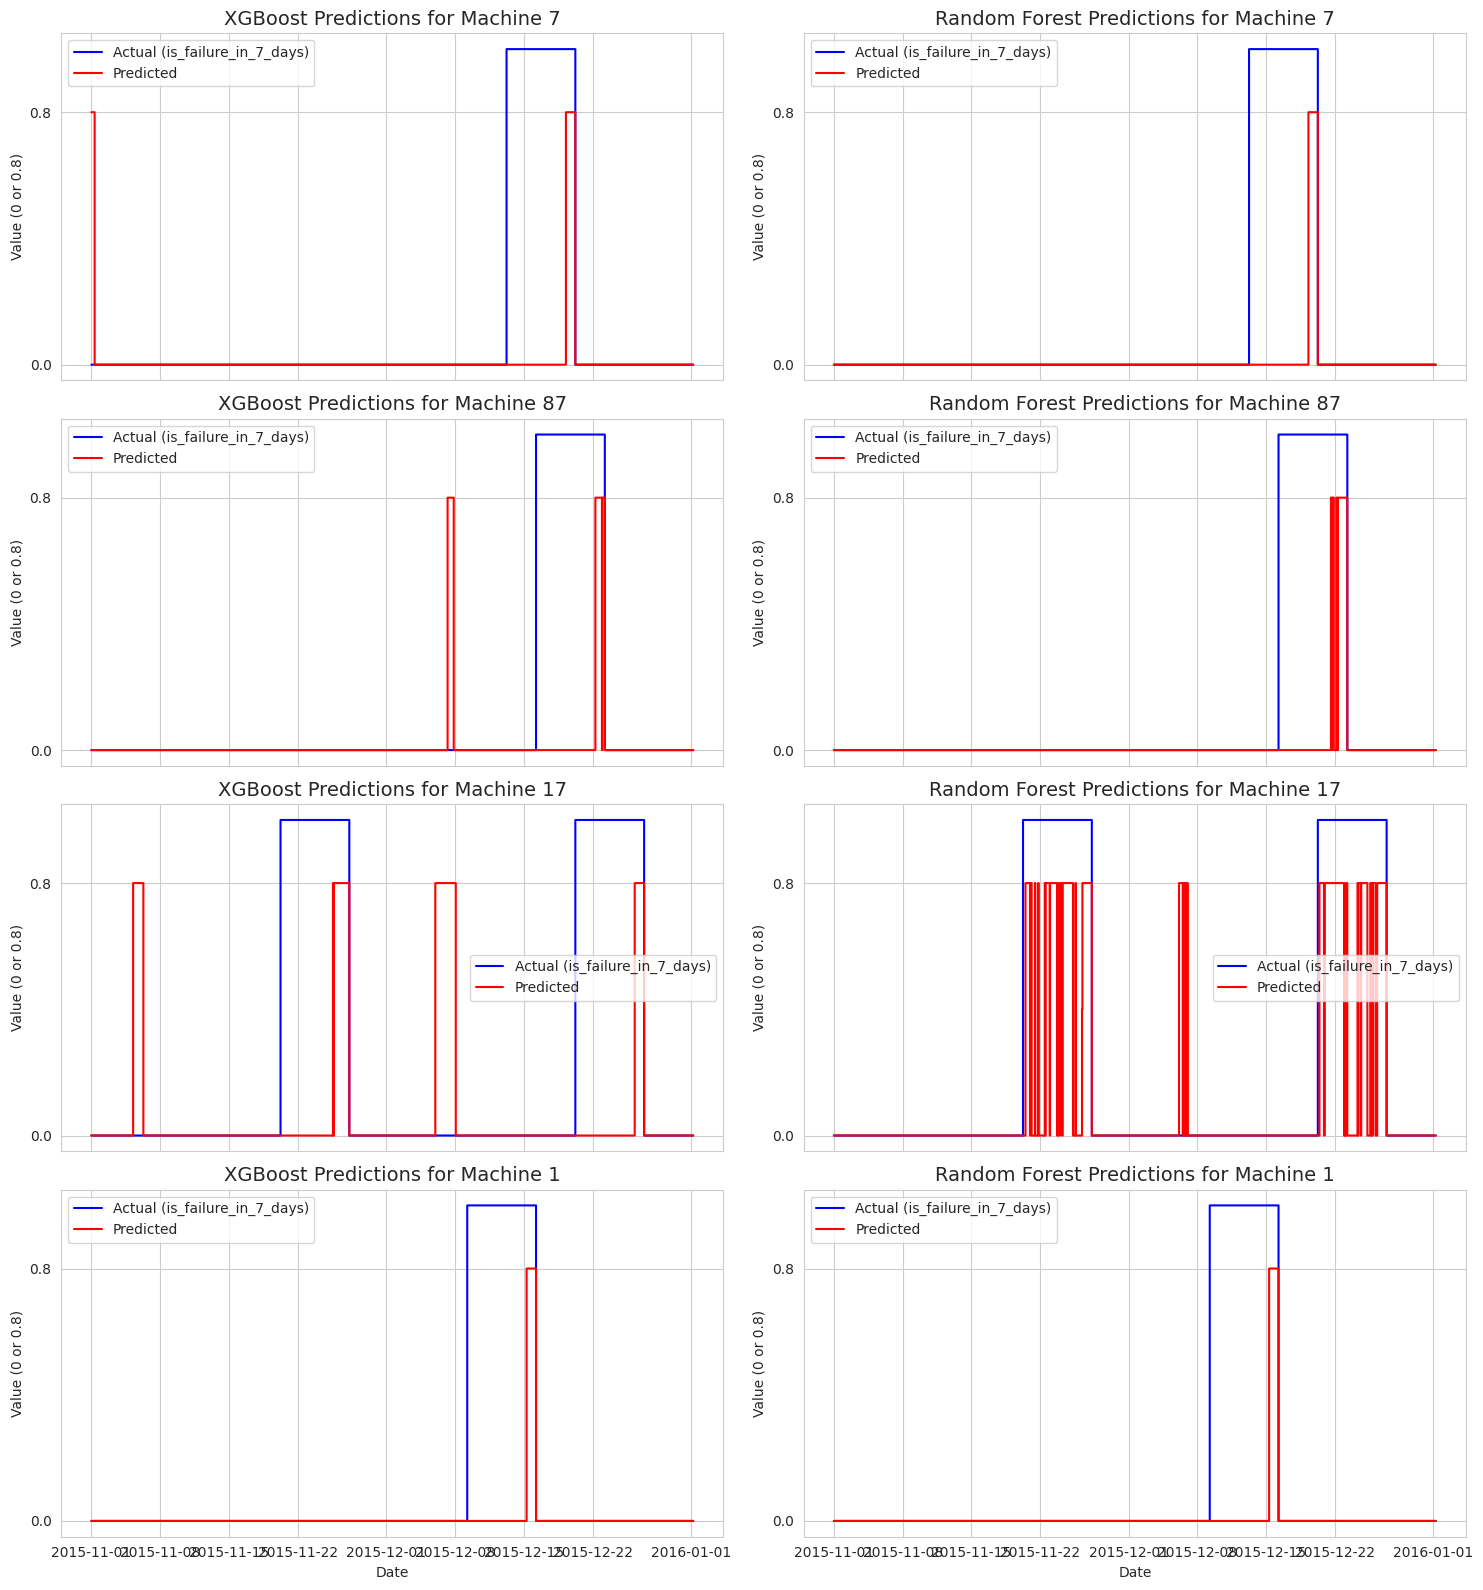

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# These optimal thresholds were determined from previous analysis
optimal_threshold_xgb = 0.8
optimal_threshold_rf = 0.75

# Get a list of machine IDs from the test set that had at least one failure
# This is crucial for the plots to show a pre-failure window
# Note: df_test, X_test_processed, and best_models are assumed to be available
machines_with_failures = df_test[df_test['is_failure'] == 1]['machineID'].unique()

# Select a few random machine IDs for plotting
np.random.seed(42) # for reproducibility
selected_machine_ids = np.random.choice(machines_with_failures, size=4, replace=False)

# Get the probability scores for both models
y_scores_xgb = best_xgb_clf.predict_proba(X_test_processed)[:, 1]
y_scores_rf = best_rf_clf.predict_proba(X_test_processed)[:, 1]

# Apply the optimal threshold to get the final predictions for both models
y_pred_xgb_optimal = (y_scores_xgb >= optimal_threshold_xgb).astype(int)
y_pred_rf_optimal = (y_scores_rf >= optimal_threshold_rf).astype(int)

# Create a master dataframe with predictions and actuals for plotting
df_test_plot = df_test.copy()
df_test_plot['y_pred_xgb_optimal'] = y_pred_xgb_optimal
df_test_plot['y_pred_rf_optimal'] = y_pred_rf_optimal

# Adjust the predicted values for visualization: 1s will be plotted at 0.8
df_test_plot['y_pred_xgb_offset'] = np.where(df_test_plot['y_pred_xgb_optimal'] == 1, 0.8, 0)
df_test_plot['y_pred_rf_offset'] = np.where(df_test_plot['y_pred_rf_optimal'] == 1, 0.8, 0)


# Set up the plotting grid
fig, axes = plt.subplots(nrows=len(selected_machine_ids), ncols=2, figsize=(15, 4 * len(selected_machine_ids)), sharex=True)

# Loop through each selected machine ID and plot
for i, machine_id in enumerate(selected_machine_ids):
    # Filter data for the current machine
    machine_df = df_test_plot[df_test_plot['machineID'] == machine_id].copy()

    # --- Plotting for XGBoost (left subplot) ---
    axes[i, 0].set_title(f"XGBoost Predictions for Machine {machine_id}", fontsize=14)
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='is_failure_in_7_days',
        ax=axes[i, 0],
        color='blue',
        drawstyle='steps-post',
        label='Actual (is_failure_in_7_days)'
    )
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='y_pred_xgb_offset', # Use the new offset column
        ax=axes[i, 0],
        color='red',
        drawstyle='steps-post',
        label='Predicted'
    )
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel("Value (0 or 0.8)")
    axes[i, 0].set_yticks([0, 0.8]) # Adjust y-ticks
    axes[i, 0].legend()

    # --- Plotting for Random Forest (right subplot) ---
    axes[i, 1].set_title(f"Random Forest Predictions for Machine {machine_id}", fontsize=14)
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='is_failure_in_7_days',
        ax=axes[i, 1],
        color='blue',
        drawstyle='steps-post',
        label='Actual (is_failure_in_7_days)'
    )
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='y_pred_rf_offset', # Use the new offset column
        ax=axes[i, 1],
        color='red',
        drawstyle='steps-post',
        label='Predicted'
    )
    axes[i, 1].set_xlabel("Date")
    axes[i, 1].set_ylabel("Value (0 or 0.8)")
    axes[i, 1].set_yticks([0, 0.8]) # Adjust y-ticks
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [52]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier

# # NOTE: y_scores_rf and df_test are assumed to be available
# # from your previous model evaluation steps.

# # Step 1: Get the model's prediction probabilities (scores)
# # y_scores_rf = best_rf_clf.predict_proba(X_test_processed)[:, 1]

# Step 2: Define the thresholds for your risk levels
threshold_high_risk = 0.7
threshold_medium_risk = 0.2

# Step 3: Create a function to assign a risk level based on the probability score
def get_risk_level(prob):
    """
    Assigns a risk level (High, Medium, or Low) based on a probability score.
    """
    if prob >= threshold_high_risk:
        return 'High'
    elif prob >= threshold_medium_risk:
        return 'Medium'
    else:
        return 'Low'

# Step 4: Apply the function to your probability scores and add a new column
# Let's create a temporary DataFrame for demonstration purposes
df_results = pd.DataFrame({
    'y_scores_rf': y_scores_rf,
    'is_failure': df_test['is_failure']
})

df_results['risk_level'] = df_results['y_scores_rf'].apply(get_risk_level)

# Display the first few rows to show the new column
print("DataFrame with assigned risk levels:")
print(df_results.head())

# Step 5 (Optional): Count and visualize the distribution of risk levels
print("\nDistribution of risk levels:")
print(df_results['risk_level'].value_counts())

# Now you can use this 'risk_level' column to prioritize actions in your business logic.

DataFrame with assigned risk levels:
   y_scores_rf  is_failure risk_level
0     0.031157         0.0        Low
1     0.031149         0.0        Low
2     0.020894         0.0        Low
3     0.023526         0.0        Low
4     0.021724         0.0        Low

Distribution of risk levels:
risk_level
Low       94554
Medium    45465
High       4318
Name: count, dtype: int64


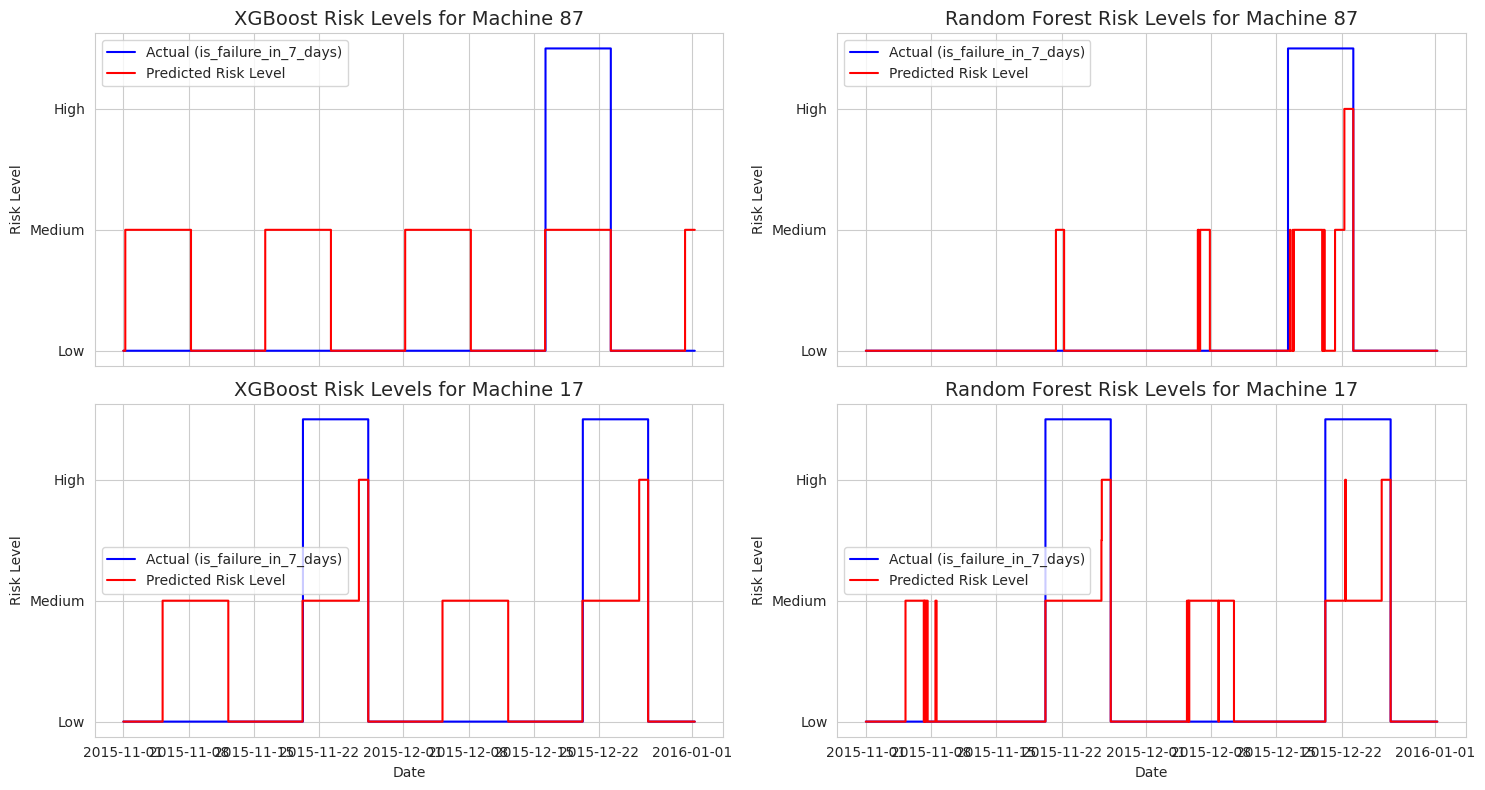

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# NOTE: y_scores_xgb and y_scores_rf are assumed to be available
#       as are the DataFrames df_test and df_test_plot from previous steps.

# Define risk level thresholds
threshold_high_risk = 0.86
threshold_medium_risk = 0.5

# Function to assign a risk level string
def get_risk_level(prob):
    if prob >= threshold_high_risk:
        return 'High'
    elif prob >= threshold_medium_risk:
        return 'Medium'
    else:
        return 'Low'

# Map string risk levels to numerical values for plotting
risk_level_mapping = {'Low': 0.0, 'Medium': 0.4, 'High': 0.8}

# Create a copy of the test data for plotting
df_test_plot = df_test.copy()

# Add the risk level for each model
df_test_plot['risk_level_xgb'] = np.vectorize(get_risk_level)(y_scores_xgb)
df_test_plot['risk_level_rf'] = np.vectorize(get_risk_level)(y_scores_rf)

# Map the string risk levels to numerical values for plotting
df_test_plot['risk_level_xgb_num'] = df_test_plot['risk_level_xgb'].map(risk_level_mapping)
df_test_plot['risk_level_rf_num'] = df_test_plot['risk_level_rf'].map(risk_level_mapping)

# Filter for the machines we want to plot
selected_machine_ids = [87, 17]

# Set up the plotting grid
fig, axes = plt.subplots(nrows=len(selected_machine_ids), ncols=2, figsize=(15, 8), sharex=True)

# Loop through each selected machine ID and plot
for i, machine_id in enumerate(selected_machine_ids):
    machine_df = df_test_plot[df_test_plot['machineID'] == machine_id].copy()

    # --- Plotting for XGBoost (left subplot) ---
    axes[i, 0].set_title(f"XGBoost Risk Levels for Machine {machine_id}", fontsize=14)
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='is_failure_in_7_days',
        ax=axes[i, 0],
        color='blue',
        drawstyle='steps-post',
        label='Actual (is_failure_in_7_days)'
    )
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='risk_level_xgb_num',
        ax=axes[i, 0],
        color='red',
        drawstyle='steps-post',
        label='Predicted Risk Level'
    )
    axes[i, 0].set_xlabel("Date")
    axes[i, 0].set_ylabel("Risk Level")
    axes[i, 0].set_yticks(list(risk_level_mapping.values()))
    axes[i, 0].set_yticklabels(list(risk_level_mapping.keys()))
    axes[i, 0].legend()

    # --- Plotting for Random Forest (right subplot) ---
    axes[i, 1].set_title(f"Random Forest Risk Levels for Machine {machine_id}", fontsize=14)
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='is_failure_in_7_days',
        ax=axes[i, 1],
        color='blue',
        drawstyle='steps-post',
        label='Actual (is_failure_in_7_days)'
    )
    sns.lineplot(
        data=machine_df,
        x='datetime',
        y='risk_level_rf_num',
        ax=axes[i, 1],
        color='red',
        drawstyle='steps-post',
        label='Predicted Risk Level'
    )
    axes[i, 1].set_xlabel("Date")
    axes[i, 1].set_ylabel("Risk Level")
    axes[i, 1].set_yticks(list(risk_level_mapping.values()))
    axes[i, 1].set_yticklabels(list(risk_level_mapping.keys()))
    axes[i, 1].legend()

plt.tight_layout()
plt.show()